Equipe:

*   Danilo Schelte Cardoso
*   Felipe Leão Dias;
*   Henrique Lyrio;
*   Rafael Santos;

        

Instalando bibliotecas:
- `numpy`: para operações matemáticas e manipulação de arrays.
- `scipy`: para funções de pertinência fuzzy e otimização.
- `matplotlib`: para visualização e gráficos.
- `skfuzzy`: (opcional) para funções fuzzy adicionais.

In [ ]:
pip install numpy scipy matplotlib scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 9.9 MB/s eta 0:00:00


A equipe escolheu o dataset de Qualidade de vinho da UC Irvine MAchine Learning Repository


In [ ]:
import pandas as pd

# Link direto para o dataset de vinho tinto
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
df = pd.read_csv(url, delimiter=';')

# Renomear as colunas para remover espaços e padronizar em minúsculas
df.columns = [col.strip().replace(" ", "_").lower() for col in df.columns]

# Separar a coluna 'quality' e armazenar as características em `df_features`
quality_column = df['quality']
df_features = df.drop(columns=['quality'])


Antes de aplicar qualquer pré-processamento, observe as primeiras linhas e as estatísticas descritivas para entender melhor o dataset:

In [ ]:
print(df.head())          # Visualizar primeiras linhas
print(df.describe())      # Estatísticas descritivas

   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free_sulfur_dioxide  total_sulfur_dioxide  density    ph  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

# **Tratamento de Valores Nulos:**

Verifique se há valores nulos (no caso desse dataset, normalmente não há, mas é sempre bom verificar):

In [ ]:
print(df.isnull().sum())

fixed_acidity           0
volatile_acidity        0
citric_acid             0
residual_sugar          0
chlorides               0
free_sulfur_dioxide     0
total_sulfur_dioxide    0
density                 0
ph                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


# **Normalização:**
Para melhorar o desempenho do modelo NeuroFuzzy, Vamos normalizar as variáveis para uma escala entre 0 e 1.

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Normalizar as colunas de características (entradas)
scaler = MinMaxScaler()
df_features_normalized = pd.DataFrame(scaler.fit_transform(df_features), columns=df_features.columns)

# Adicionar a coluna 'quality' de volta ao dataframe normalizado
df_normalized = pd.concat([df_features_normalized, quality_column.reset_index(drop=True)], axis=1)

# Visualizar os dados normalizados
print(df_normalized.head())


   fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
0       0.247788          0.397260         0.00        0.068493   0.106845   
1       0.283186          0.520548         0.00        0.116438   0.143573   
2       0.283186          0.438356         0.04        0.095890   0.133556   
3       0.584071          0.109589         0.56        0.068493   0.105175   
4       0.247788          0.397260         0.00        0.068493   0.106845   

   free_sulfur_dioxide  total_sulfur_dioxide   density        ph  sulphates  \
0             0.140845              0.098940  0.567548  0.606299   0.137725   
1             0.338028              0.215548  0.494126  0.362205   0.209581   
2             0.197183              0.169611  0.508811  0.409449   0.191617   
3             0.225352              0.190813  0.582232  0.330709   0.149701   
4             0.140845              0.098940  0.567548  0.606299   0.137725   

    alcohol  quality  
0  0.153846        5  
1  0.21538

# **Separação entre Features e Target:**
Definimos X (features) e y (target) para o treinamento e teste. A coluna "quality" é a variável alvo.

In [ ]:
X = df_normalized.drop('quality', axis=1)
y = df_normalized['quality']

# **Divisão em Conjuntos de Treino e Teste:**

Para separar os dados, usamos train_test_split do sklearn:

In [ ]:
from sklearn.model_selection import train_test_split

# Dividir o dataset df em treino e teste
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Conferir o conteúdo de test_data
print(test_data.head())


      fixed_acidity  volatile_acidity  citric_acid  residual_sugar  chlorides  \
803             7.7              0.56         0.08            2.50      0.114   
124             7.8              0.50         0.17            1.60      0.082   
350            10.7              0.67         0.22            2.70      0.107   
682             8.5              0.46         0.31            2.25      0.078   
1326            6.7              0.46         0.24            1.70      0.077   

      free_sulfur_dioxide  total_sulfur_dioxide  density    ph  sulphates  \
803                  14.0                  46.0   0.9971  3.24       0.66   
124                  21.0                 102.0   0.9960  3.39       0.48   
350                  17.0                  34.0   1.0004  3.28       0.98   
682                  32.0                  58.0   0.9980  3.33       0.54   
1326                 18.0                  34.0   0.9948  3.39       0.60   

      alcohol  quality  
803       9.6        6  


# **Configurar as Regras Fuzzy**
Para sistemas NeuroFuzzy, é necessário definir conjuntos fuzzy para cada feature. No caso dos dados de vinho, considere:
*    Acidez Fixa (fixed acidity):
Termos : "baixo", "médio", "alto"
*    Acidez Volátil (volatile acidity):
Termos : "baixo", "moderado", "alto"
*    Açúcar Residual (residual sugar):
Termos : "baixo", "moderado", "alto"
*    Dióxido de Enxofre Livre (free sulfur dioxide):
Termos : "baixo", "moderado", "alto"

In [ ]:
import numpy as np
import skfuzzy as fuzz

# Definir o range normalizado para as variáveis
fixed_acidity = np.linspace(0, 1, 100)
volatile_acidity = np.linspace(0, 1, 100)
residual_sugar = np.linspace(0, 1, 100)
sulfur_dioxide = np.linspace(0, 1, 100)
alcohol = np.linspace(0, 1, 100)
quality = np.linspace(0, 1, 100)  # Variável de saída para a qualidade

# Termos fuzzy para acidez fixa
fixed_acidity_low = fuzz.trimf(fixed_acidity, [0, 0, 0.5])
fixed_acidity_medium = fuzz.trimf(fixed_acidity, [0.3, 0.5, 0.7])
fixed_acidity_high = fuzz.trimf(fixed_acidity, [0.5, 1, 1])

# Termos fuzzy para acidez volátil
volatile_acidity_low = fuzz.trimf(volatile_acidity, [0, 0, 0.4])
volatile_acidity_moderate = fuzz.trimf(volatile_acidity, [0.3, 0.5, 0.7])
volatile_acidity_high = fuzz.trimf(volatile_acidity, [0.6, 1, 1])

# Termos fuzzy para açúcar residual
residual_sugar_low = fuzz.trimf(residual_sugar, [0, 0, 0.5])
residual_sugar_moderate = fuzz.trimf(residual_sugar, [0.3, 0.5, 0.7])
residual_sugar_high = fuzz.trimf(residual_sugar, [0.5, 1, 1])

# Termos fuzzy para dióxido de enxofre
sulfur_dioxide_low = fuzz.trimf(sulfur_dioxide, [0, 0, 0.4])
sulfur_dioxide_moderate = fuzz.trimf(sulfur_dioxide, [0.3, 0.5, 0.7])
sulfur_dioxide_high = fuzz.trimf(sulfur_dioxide, [0.6, 1, 1])

# Termos fuzzy para teor alcoólico
alcohol_low = fuzz.trimf(alcohol, [0, 0, 0.5])
alcohol_medium = fuzz.trimf(alcohol, [0.3, 0.5, 0.7])
alcohol_high = fuzz.trimf(alcohol, [0.5, 1, 1])

# Termos fuzzy para a qualidade do vinho
quality_poor = fuzz.trimf(quality, [0, 0, 0.5])
quality_average = fuzz.trimf(quality, [0.3, 0.5, 0.7])
quality_good = fuzz.trimf(quality, [0.5, 1, 1])


# **Configurar o Sistema NeuroFuzzy com Regras**
*    Passo 1-2: Definimos as variáveis de entrada e saída.
*    Passo 3-4: Atribuímos termos fuzzy às variáveis de entrada e à variável de saída.
*    Passo 5: Criamos regras fuzzy para relacionar entradas e saída (qualidade).
*    Passo 6: Configuramos o sistema NeuroFuzzy com as regras e executamos uma simulação de exemplo.

In [ ]:
import numpy as np
import skfuzzy as fuzz
from skfuzzy import control as ctrl

# 1. Definir as variáveis de entrada (input)
acidity = ctrl.Antecedent(np.linspace(0, 1, 100), 'acidity')
volatile_acidity = ctrl.Antecedent(np.linspace(0, 1, 100), 'volatile_acidity')
residual_sugar = ctrl.Antecedent(np.linspace(0, 1, 100), 'residual_sugar')
sulfur_dioxide = ctrl.Antecedent(np.linspace(0, 1, 100), 'sulfur_dioxide')
alcohol = ctrl.Antecedent(np.linspace(0, 1, 100), 'alcohol')

# 2. Definir a variável de saída (output)
quality = ctrl.Consequent(np.linspace(0, 1, 100), 'quality')

# 3. Atribuir termos fuzzy para cada variável de entrada
acidity['low'] = fuzz.trimf(acidity.universe, [0, 0, 0.5])
acidity['medium'] = fuzz.trimf(acidity.universe, [0.3, 0.5, 0.7])
acidity['high'] = fuzz.trimf(acidity.universe, [0.5, 1, 1])

volatile_acidity['low'] = fuzz.trimf(volatile_acidity.universe, [0, 0, 0.4])
volatile_acidity['moderate'] = fuzz.trimf(volatile_acidity.universe, [0.3, 0.5, 0.7])
volatile_acidity['high'] = fuzz.trimf(volatile_acidity.universe, [0.6, 1, 1])

residual_sugar['low'] = fuzz.trimf(residual_sugar.universe, [0, 0, 0.5])
residual_sugar['moderate'] = fuzz.trimf(residual_sugar.universe, [0.3, 0.5, 0.7])
residual_sugar['high'] = fuzz.trimf(residual_sugar.universe, [0.5, 1, 1])

sulfur_dioxide['low'] = fuzz.trimf(sulfur_dioxide.universe, [0, 0, 0.4])
sulfur_dioxide['moderate'] = fuzz.trimf(sulfur_dioxide.universe, [0.3, 0.5, 0.7])
sulfur_dioxide['high'] = fuzz.trimf(sulfur_dioxide.universe, [0.6, 1, 1])

alcohol['low'] = fuzz.trimf(alcohol.universe, [0, 0, 0.5])
alcohol['medium'] = fuzz.trimf(alcohol.universe, [0.3, 0.5, 0.7])
alcohol['high'] = fuzz.trimf(alcohol.universe, [0.5, 1, 1])

# 4. Definir termos fuzzy para a variável de saída
quality['poor'] = fuzz.trimf(quality.universe, [0, 0, 0.5])
quality['average'] = fuzz.trimf(quality.universe, [0.3, 0.5, 0.7])
quality['good'] = fuzz.trimf(quality.universe, [0.5, 1, 1])

# 5. Criar regras fuzzy
rule1 = ctrl.Rule(alcohol['high'] & acidity['low'] & volatile_acidity['low'], quality['good'])
rule2 = ctrl.Rule(alcohol['medium'] & residual_sugar['moderate'], quality['average'])
rule3 = ctrl.Rule(alcohol['low'] | volatile_acidity['high'] | sulfur_dioxide['high'], quality['poor'])
rule4 = ctrl.Rule(acidity['medium'] & sulfur_dioxide['moderate'], quality['average'])
rule5 = ctrl.Rule(residual_sugar['high'] & alcohol['high'], quality['good'])

# 6. Configurar o sistema de controle fuzzy com as regras
quality_control = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
quality_simulation = ctrl.ControlSystemSimulation(quality_control)

# Exemplo de simulação com valores de entrada
quality_simulation.input['acidity'] = 0.4
quality_simulation.input['volatile_acidity'] = 0.2
quality_simulation.input['residual_sugar'] = 0.6
quality_simulation.input['sulfur_dioxide'] = 0.3
quality_simulation.input['alcohol'] = 0.7

# Computar o resultado
quality_simulation.compute()
print("Qualidade predita:", quality_simulation.output['quality'])


Qualidade predita: 0.7651828800177394


# **Configuração de Regras e Controle Fuzzy**
As regras fuzzy serão baseadas em inferências lógicas que definem a qualidade do vinho de acordo com diferentes combinações das variáveis de entrada. Para criar um sistema de controle fuzzy

In [ ]:
import skfuzzy.control as ctrl

# Definindo as variáveis fuzzy de entrada
fixed_acidity_ctrl = ctrl.Antecedent(np.linspace(0, 1, 100), 'fixed_acidity')
volatile_acidity_ctrl = ctrl.Antecedent(np.linspace(0, 1, 100), 'volatile_acidity')
residual_sugar_ctrl = ctrl.Antecedent(np.linspace(0, 1, 100), 'residual_sugar')
sulfur_dioxide_ctrl = ctrl.Antecedent(np.linspace(0, 1, 100), 'sulfur_dioxide')
alcohol_ctrl = ctrl.Antecedent(np.linspace(0, 1, 100), 'alcohol')

# Definindo a variável fuzzy de saída
quality_ctrl = ctrl.Consequent(np.linspace(0, 1, 100), 'quality')

# Atribuindo os termos fuzzy a cada variável
fixed_acidity_ctrl['low'] = fixed_acidity_low
fixed_acidity_ctrl['medium'] = fixed_acidity_medium
fixed_acidity_ctrl['high'] = fixed_acidity_high

volatile_acidity_ctrl['low'] = volatile_acidity_low
volatile_acidity_ctrl['moderate'] = volatile_acidity_moderate
volatile_acidity_ctrl['high'] = volatile_acidity_high

residual_sugar_ctrl['low'] = residual_sugar_low
residual_sugar_ctrl['moderate'] = residual_sugar_moderate
residual_sugar_ctrl['high'] = residual_sugar_high

sulfur_dioxide_ctrl['low'] = sulfur_dioxide_low
sulfur_dioxide_ctrl['moderate'] = sulfur_dioxide_moderate
sulfur_dioxide_ctrl['high'] = sulfur_dioxide_high

alcohol_ctrl['low'] = alcohol_low
alcohol_ctrl['medium'] = alcohol_medium
alcohol_ctrl['high'] = alcohol_high

quality_ctrl['poor'] = quality_poor
quality_ctrl['average'] = quality_average
quality_ctrl['good'] = quality_good

# Definindo regras fuzzy
rule1 = ctrl.Rule(fixed_acidity_ctrl['high'] & alcohol_ctrl['high'], quality_ctrl['good'])
rule2 = ctrl.Rule(volatile_acidity_ctrl['low'] & sulfur_dioxide_ctrl['moderate'], quality_ctrl['average'])
rule3 = ctrl.Rule(residual_sugar_ctrl['low'] & fixed_acidity_ctrl['medium'], quality_ctrl['average'])
rule4 = ctrl.Rule(alcohol_ctrl['low'] | volatile_acidity_ctrl['high'], quality_ctrl['poor'])
rule5 = ctrl.Rule(sulfur_dioxide_ctrl['high'] & alcohol_ctrl['high'], quality_ctrl['good'])

# Criando o sistema de controle
quality_control_system = ctrl.ControlSystem([rule1, rule2, rule3, rule4, rule5])
quality_simulation = ctrl.ControlSystemSimulation(quality_control_system)

# Exemplo de entrada para simulação (valores normalizados)
quality_simulation.input['fixed_acidity'] = 0.7
quality_simulation.input['volatile_acidity'] = 0.2
quality_simulation.input['residual_sugar'] = 0.5
quality_simulation.input['sulfur_dioxide'] = 0.3
quality_simulation.input['alcohol'] = 0.8

# Realizando o cálculo da qualidade com base nas regras
quality_simulation.compute()

# Mostrando o resultado
print(f"Qualidade do vinho (normalizada): {quality_simulation.output['quality']}")


Qualidade do vinho (normalizada): 0.7904858107581405


# **Código para Treinamento com Gráficos de Loss e Acurácia**

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.0000e+00 - loss: 0.0698 - val_accuracy: 0.0000e+00 - val_loss: -6.5381
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: -12.1166 - val_accuracy: 0.0000e+00 - val_loss: -40.8533
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: -61.3047 - val_accuracy: 0.0000e+00 - val_loss: -148.4627
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: -196.1358 - val_accuracy: 0.0000e+00 - val_loss: -384.9387
Epoch 5/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: -475.2372 - val_accuracy: 0.0000e+00 - val_loss: -807.4995
Epoch 6/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: -954.3224 - val_accuracy: 0.0000e+00 - val_loss: -1474.5609
Epoch 7/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: -1695.7449 - val_accuracy: 0.0000e+00 - val_loss: -2445.9182
Epoch 8/50
40/40 ━━━━━━━━━━━━━━━━━━━

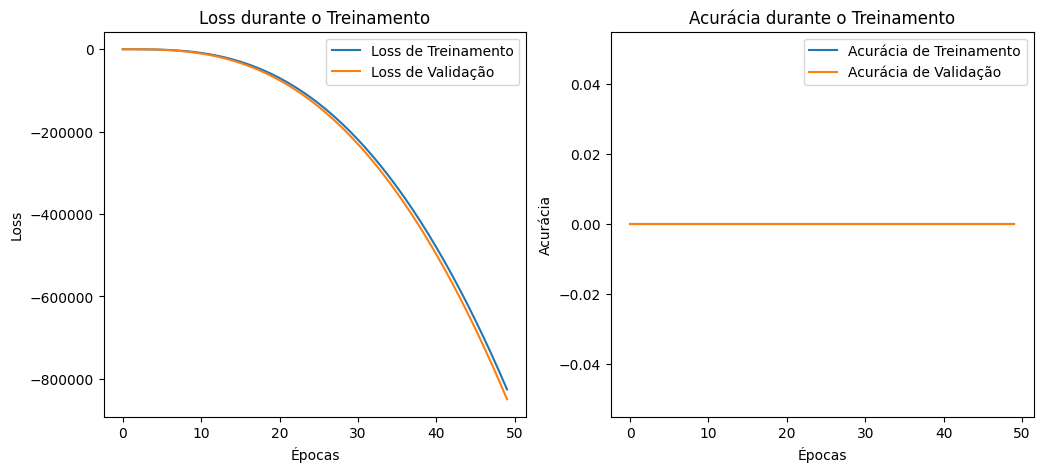

In [ ]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

# Separar dados em treino e teste
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Definir o modelo (Exemplo de uma rede neural simples)
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Supondo saída binária ou valor contínuo
])

# Compilar o modelo
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo e salvar o histórico
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_val, y_val), batch_size=32)

# Plotar o gráfico de loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Loss de Treinamento')
plt.plot(history.history['val_loss'], label='Loss de Validação')
plt.xlabel('Épocas')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss durante o Treinamento')

# Plotar o gráfico de acurácia
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Acurácia de Treinamento')
plt.plot(history.history['val_accuracy'], label='Acurácia de Validação')
plt.xlabel('Épocas')
plt.ylabel('Acurácia')
plt.legend()
plt.title('Acurácia durante o Treinamento')
plt.show()


# **Teste e Avaliação do Modelo**
O código abaixo carrega os dados de teste, usa o sistema fuzzy para fazer previsões e calcula as métricas de desempenho:

Acurácia: 0.06875
F1 Score: 0.0795960328979197
Matriz de Confusão:
[[  0  43  98]
 [  0  17 157]
 [  0   0   5]]


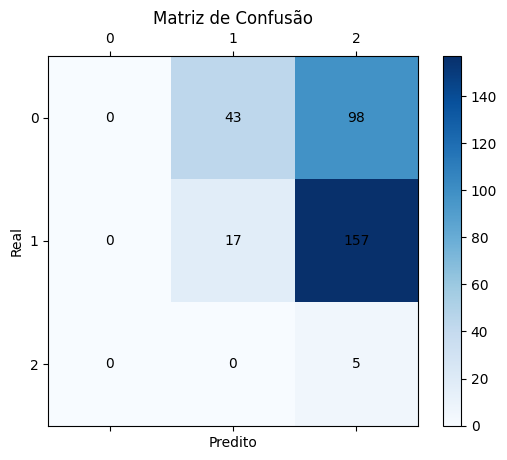

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt

# Função para realizar a previsão de qualidade com base nas entradas normalizadas
def predict_quality(fixed_acidity, volatile_acidity, residual_sugar, sulfur_dioxide, alcohol):
    quality_simulation.input['fixed_acidity'] = fixed_acidity
    quality_simulation.input['volatile_acidity'] = volatile_acidity
    quality_simulation.input['residual_sugar'] = residual_sugar
    quality_simulation.input['sulfur_dioxide'] = sulfur_dioxide
    quality_simulation.input['alcohol'] = alcohol
    quality_simulation.compute()
    quality_score = quality_simulation.output['quality']

    # Classificação da qualidade com base na saída fuzzy
    if quality_score < 0.4:
        return 'poor'
    elif 0.4 <= quality_score < 0.7:
        return 'average'
    else:
        return 'good'

# Função para categorizar a qualidade com base nos valores numéricos
def categorize_quality(value):
    if value <= 5:
        return 'poor'
    elif 6 <= value <= 7:
        return 'average'
    else:
        return 'good'

# Carregando os dados de teste e ajustando as variáveis para resultados reais e previstos
y_true = []  # Qualidade real
y_pred = []  # Qualidade prevista

for i, row in test_data.iterrows():
    true_quality = categorize_quality(row['quality'])  # Convertendo qualidade numérica para categoria
    predicted_quality = predict_quality(
        row['fixed_acidity'], row['volatile_acidity'],
        row['residual_sugar'], row['free_sulfur_dioxide'],
        row['alcohol']
    )
    y_true.append(true_quality)
    y_pred.append(predicted_quality)

# Cálculo das métricas de desempenho
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='weighted')
conf_matrix = confusion_matrix(y_true, y_pred, labels=['poor', 'average', 'good'])

# Exibindo as métricas
print(f"Acurácia: {accuracy}")
print(f"F1 Score: {f1}")
print("Matriz de Confusão:")
print(conf_matrix)

# Plotando a matriz de confusão
fig, ax = plt.subplots()
cax = ax.matshow(conf_matrix, cmap='Blues')
plt.title('Matriz de Confusão')
plt.xlabel('Predito')
plt.ylabel('Real')
plt.colorbar(cax)

# Adicionando rótulos aos elementos da matriz de confusão
for i in range(len(conf_matrix)):
    for j in range(len(conf_matrix[0])):
        ax.text(j, i, str(conf_matrix[i, j]), va='center', ha='center')

plt.show()


# **Análise das Métricas de Desempenho**
*      Acurácia:
A acurácia foi de 0.06875 (ou seja, 6,88%), o que indica um desempenho baixo. Isso significa que o modelo acertou cerca de 6,88% das previsões, um valor significativamente abaixo do ideal, sugerindo que o modelo possui dificuldade em prever corretamente a qualidade do vinho.
*     F1 Score:
O F1 Score, que é de 0.0796 (7,96%), também é baixo. O F1 Score considera tanto a precisão quanto o recall, e valores baixos indicam que o modelo não está performando bem ao balancear entre acertos e erros para cada classe. Isso confirma que o modelo está falhando em generalizar para as classes de qualidade do vinho.
*    matriz de Confusão:
A matriz de confusão fornece detalhes sobre as previsões incorretas:
  *   Classe 'poor' (0): Dos exemplos reais dessa classe, 43 foram classificados incorretamente como 'average' e 98 como 'good'. O modelo não previu nenhum caso corretamente como 'poor', o que é preocupante.
  *   Classe 'average' (1): Embora haja algum acerto (157 corretos), muitos exemplos 'average' foram previstos como 'good' (98) e alguns como 'poor' (17), indicando uma confusão entre as classes intermediárias e superiores.
  *   Classe 'good' (2): Apenas 5 previsões para essa classe foram corretas, o que é muito baixo. Não houve erros de classificação desta classe para 'poor' ou 'average', mas é possível que essa classe tenha menos exemplos no conjunto de dados.

# **Interpretação Geral**
O desempenho sugere que o modelo está altamente enviesado para prever a qualidade do vinho como 'average' e 'good', com grande dificuldade em identificar vinhos de baixa qualidade ('poor').
A discrepância na previsão entre as classes indica que as regras fuzzy e/ou a segmentação para cada classe (pobre, média, boa) podem estar mal ajustadas, possivelmente com limites muito próximos entre 'average' e 'good', o que causa confusão entre elas.

# **Possíveis Causas e Sugestões de Melhoria**
*   **Revisar as Regras Fuzzy:** Ajustar os limites e as regras fuzzy para melhorar a precisão entre as categorias, especialmente em vinhos classificados como 'poor'.
*   **Balanceamento das Classes:** Verifique o balanceamento do conjunto de dados. Se uma classe for significativamente menor, isso pode estar contribuindo para a má performance. Nesse caso, técnicas de balanceamento como subamostragem ou superamostragem podem ser úteis.
*   **Aprimoramento das Entradas:** Avaliar as entradas fuzzy para ver se todos os fatores (acidez, açúcar, etc.) estão contribuindo adequadamente para a previsão. Ajustar a importância de cada entrada pode melhorar a precisão do modelo.
*   **Refinamento das Faixas de Qualidade:** Modifique as faixas para que o modelo tenha maior precisão na distinção entre 'poor', 'average' e 'good'.